In [1]:
# Copyright (c) OpenMMLab. All rights reserved.
from osgeo import gdal
import argparse
import glob
import math
import os
import os.path as osp
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

import numpy as np
from mmengine.utils import ProgressBar, mkdir_or_exist
from tqdm import tqdm
from time import time
import logging
from ATL_Tools import mkdir_or_exist, find_data_list
from matplotlib import pyplot as plt
import matplotlib
import cv2

train_num: 133
drop_num: 140


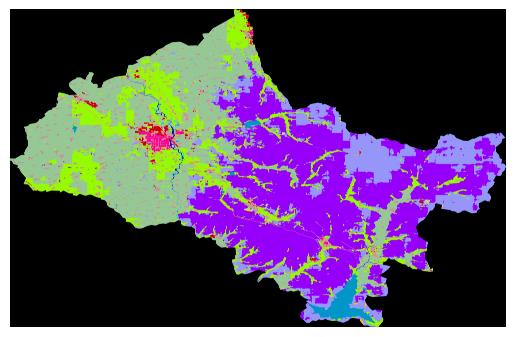

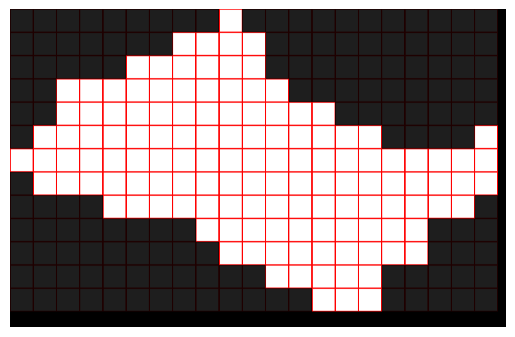

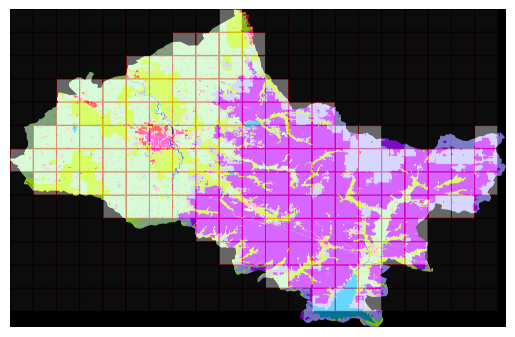

In [4]:
label_path_all = '/opt/AI-Tianlong/Datasets/ATL-ATLNongYe/0-黑龙江省-哨兵2号-数据集-矢量裁切/1-根据矢量裁切的大图/黑龙江省-24类地物-labels/哈尔滨市/S2_SR_2019_黑龙江省_哈尔滨市_阿城区.tif'
label_np = np.array(Image.open(label_path_all)).astype(np.uint8)
label_h, label_w = label_np.shape
label_3chan = np.stack((label_np, label_np, label_np), axis=-1)

# 图像的crop_size
crop_size = 512
vis_label = np.zeros((label_h, label_w, 3), dtype=np.uint8)

# 画线的线宽
line_width = 15

# 有效面积阈值
Effective_Area_Threshould = 0.5
drop_ratio = 1 - Effective_Area_Threshould

# 有效裁切的数量
train_num = 0
drop_num = 0

METAINFO = dict(
    classes=("background", "industrial area", "paddy field","irrigated field",   
             "dry cropland", "garden land","arbor forest", "shrub forest",
             "park", "natural meadow",  "artificial meadow", "river",
             "urban residential", "lake", "pond", "fish pond", "snow",
             "bareland","rural residential","stadium","square","road",
             "overpass","railway station","airport"),
    palette=[[0, 0, 0], [200, 0, 0], [0, 200, 0], [150, 250, 0],
                [150, 200, 150], [200, 0, 200], [150, 0, 250],
                [150, 150, 250], [200, 150, 200], [250, 200, 0],
                [200, 200, 0], [0, 0, 200], [250, 0, 150],
                [0, 150, 200], [0, 200, 250], [150, 200, 250],
                [250, 250, 250], [200, 200, 200], [200, 150, 150],
                [250, 200, 150], [150, 150, 0], [250, 150, 150],
                [250, 150, 0], [250, 200, 250], [200, 150, 0]]
)                                                           
classes = METAINFO['classes']
palette = METAINFO['palette']
palette = np.array(palette)

# 裁切标签的512的部分
for i in range(label_h//crop_size):
    for j in range(label_w//crop_size):
        new_label_512 = np.zeros((crop_size,crop_size),dtype=np.uint8)
        new_label_512 = label_np[i*crop_size:i*crop_size+crop_size,j*crop_size:j*crop_size+crop_size]   #横着来   
        
        # 当前像素的值的集合, 判断当前小patch是否 都是无效像素
        set_label = set(new_label_512.flatten())   

        # 计算无效像素的比例
        num_pixel_0 = np.sum(new_label_512 == 0)
        total_pixels = new_label_512.size
        ratio_of_0 = num_pixel_0 / total_pixels
        # print(ratio_label_15)

        # 保留的
        # if ((len(set_label) > 1) and (ratio_of_0<=drop_ratio)) or (len(set_label)==1 and 15 not in set_label) :  #包含两种及以上的标签
        if ratio_of_0 <= drop_ratio: # 有效面积大于阈值
            vis_label[i*crop_size:i*crop_size+crop_size, j*crop_size:j*crop_size+crop_size, 0:3] = 255
            train_num += 1

        # 丢弃的
        else:
            vis_label[i*crop_size:i*crop_size+crop_size,j*crop_size:j*crop_size+crop_size,0:3] = 30
            drop_num += 1

        # 画红色网格
        vis_label[i*crop_size:i*crop_size+crop_size, j*crop_size:j*crop_size+line_width, 1:3] = 0 # 左边
        vis_label[i*crop_size:i*crop_size+crop_size, j*crop_size+crop_size-line_width:j*crop_size+crop_size, 1:3] = 0 # 右边
        vis_label[i*crop_size:i*crop_size+line_width, j*crop_size:j*crop_size+crop_size, 1:3] = 0 # 上边
        vis_label[i*crop_size+crop_size-line_width:i*crop_size+crop_size, j*crop_size:j*crop_size+crop_size, 1:3] = 0 # 下边


print('train_num:',train_num)
print('drop_num:',drop_num)


RGB_label = palette[label_np].astype(np.uint8)

plt.axis('off')
plt.imshow(RGB_label)
plt.show()

plt.axis('off')
plt.imshow(vis_label)
plt.show()

overlapping = cv2.addWeighted(RGB_label, 0.6, vis_label, 0.4, 0)
# overlapping = cv2.cvtColor(overlapping, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(overlapping)

# plt.savefig(f"{os.path.basename(label_path_all).replace('.tif','.png')}",bbox_inches='tight',pad_inches=0)
# 去掉坐标轴
plt.show()
